# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return (1 / (1 + np.exp(- (X @ weights))))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        return self.losses_weights
    
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        self.losses_weights = []
        for i in range(self.max_iter):
            delta = 0
            loss = 0
            
            for j in range(0, len(y)):
                delta += y[j]*X_ext[j,:]*(1 - 1 / (1 + np.exp(-(X_ext[j,:] @ self.weights_) * y[j])))
                loss+= np.log(1 + np.exp(-(X_ext[j,:] @ self.weights_)*y[j]))
            delta = -(1 / len(y))*delta + (1 / self.C) * self.weights_
            loss = loss / len(y) + np.square(self.weights_).sum() / (2 * self.C)
            
            self.weights_ -= self.eta * delta
            self.losses_weights.append(loss)
            
            if  np.sqrt(np.square(self.eta * delta).sum()) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        y = self.predict_proba(X)
        y[y > 0.5] = 1
        y[y <= 0.5] = -1

        return y

In [5]:
from sklearn import datasets
from sklearn import metrics

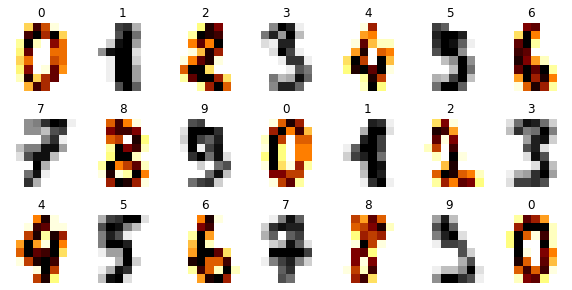

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

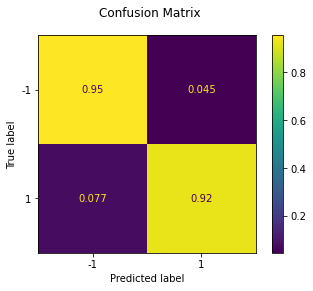

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

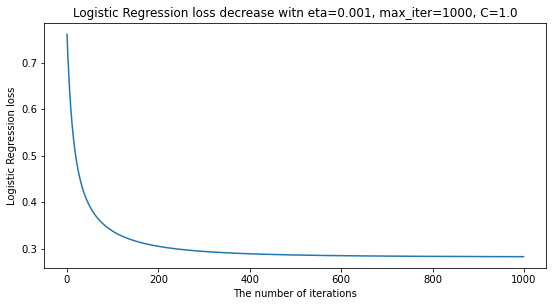

In [17]:
MAX_ITERS = list(range(0, 1000))
model = CustomLogisticRegression()
model.fit(X_train, y_train)
losses = model.get_loss(X_train, model.weights_, y_train)

plt.figure(figsize=(9, 4.5))
plt.plot(MAX_ITERS, losses)
plt.title('Logistic Regression loss decrease witn eta=0.001, max_iter=1000, C=1.0')
plt.xlabel('The number of iterations')
plt.ylabel('Logistic Regression loss')       
plt.show()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

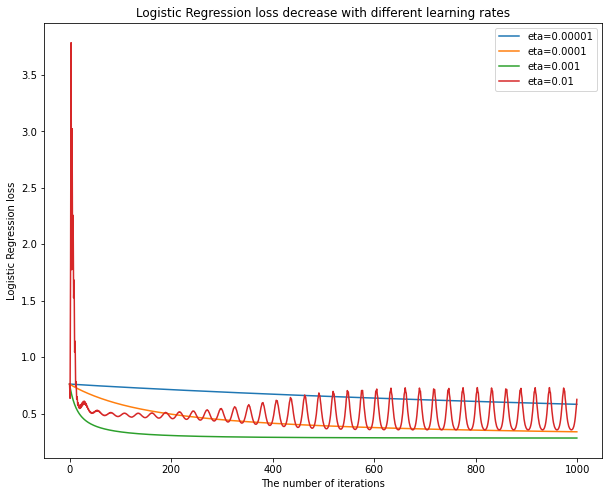

In [18]:
ETAS = [1e-5, 1e-4, 1e-3, 1e-2]

losses_etas = []
for eta in ETAS:
    model = CustomLogisticRegression(eta=eta)
    model.fit(X_train, y_train)
    losses_etas.append(model.get_loss(X_train, model.weights_, y_train))

lenghth = []
for losses in losses_etas:
    lenghth.append(len(losses))
max_iters = min(lenghth)
MAX_ITERS = list(range(0, max_iters))

plt.figure(figsize=(10, 8))
plt.plot(MAX_ITERS, losses_etas[0][:max_iters], label='eta=0.00001')
plt.plot(MAX_ITERS, losses_etas[1][:max_iters], label='eta=0.0001')
plt.plot(MAX_ITERS, losses_etas[2][:max_iters], label='eta=0.001')
plt.plot(MAX_ITERS, losses_etas[3][:max_iters], label='eta=0.01')
plt.title('Logistic Regression loss decrease with different learning rates')
plt.xlabel('The number of iterations')
plt.ylabel('Logistic Regression loss')
plt.legend(loc='best')    
plt.show()

The learning rate controls how quickly we will move towards the optimal weights.

If the learning rate is too small we will need too many iterations to converge to the best values (blue line on the plot).

If the learning rate is very large we will skip the optimal solution (red line on the plot). 

Thus we must set a good learning rate (green line on the plot, eta = 0.001).

**(0.5 points)** Try different regularization parameter values and compare the model quality.

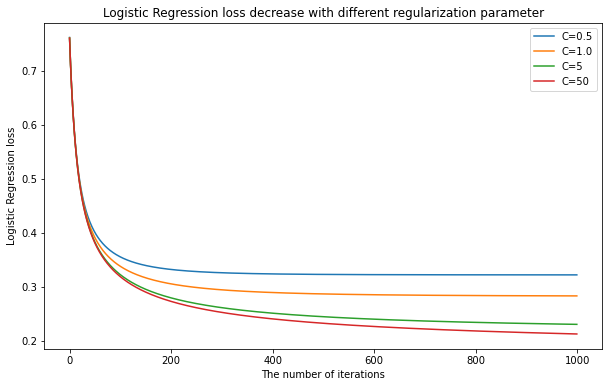

In [19]:
MAX_ITERS = list(range(0, 1000))
C_RANGE = [0.5, 1, 5, 50]
losses_c = []
quality = []
for c in C_RANGE:
    model = CustomLogisticRegression(C=c)
    model.fit(X_train, y_train)
    losses_c.append(model.get_loss(X_train, model.weights_, y_train))
    quality.append([c, metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)])

plt.figure(figsize=(10, 6))
plt.plot(MAX_ITERS, losses_c[0], label='C=0.5')
plt.plot(MAX_ITERS, losses_c[1], label='C=1.0')
plt.plot(MAX_ITERS, losses_c[2], label='C=5')
plt.plot(MAX_ITERS, losses_c[3], label='C=50')

plt.title('Logistic Regression loss decrease with different regularization parameter')
plt.xlabel('The number of iterations')
plt.ylabel('Logistic Regression loss')
plt.legend(loc='best')    
plt.show()

In [20]:
for i in quality:
    print(f"For C = {i[0]} the model's train_acc, test_acc = {i[1]}, {i[2]}")

For C = 0.5 the model's train_acc, test_acc = 0.9039665970772442, 0.9277777777777778
For C = 1 the model's train_acc, test_acc = 0.9109255393180237, 0.9388888888888889
For C = 5 the model's train_acc, test_acc = 0.9151009046624913, 0.9444444444444444
For C = 50 the model's train_acc, test_acc = 0.9144050104384134, 0.9416666666666667


The regularization parameter C means how much we take into account big values of the model's coefficients.

For small values of C (C=0.5 in our example), we increase the regularization strength which will create simple models which underfit the data.

For big values of C (C=50 in our example), we low the regularization strength which implies the model is allowed to increase it's complexity, and therefore, overfit the data.
 
Thus, the optimal value is C=5.

**(0.5 points)** Compare zero initialization and random initialization. 

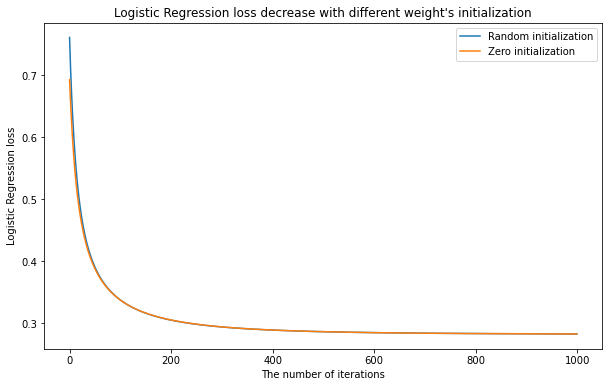

In [21]:
MAX_ITERS = list(range(0, 1000))

model_ri = CustomLogisticRegression(zero_init=False)
model_ri.fit(X_train, y_train)
losses_ri = model_ri.get_loss(X_train, model_ri.weights_, y_train)
acc_ri = metrics.accuracy_score(y_pred=model_ri.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=model_ri.predict(X_test), y_true=y_test)
                                  
model_zi = CustomLogisticRegression(zero_init=True)
model_zi.fit(X_train, y_train)
losses_zi = model_zi.get_loss(X_train, model_ri.weights_, y_train)
acc_zi = metrics.accuracy_score(y_pred=model_zi.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=model_zi.predict(X_test), y_true=y_test)

plt.figure(figsize=(10, 6))
plt.plot(MAX_ITERS, losses_ri, label='Random initialization')
plt.plot(MAX_ITERS, losses_zi, label='Zero initialization')
plt.title("Logistic Regression loss decrease with different weight's initialization")
plt.xlabel('The number of iterations')
plt.ylabel('Logistic Regression loss')
plt.legend(loc='best')    
plt.show()

In [23]:
print(f"For the model with random initialization:\ntrain_acc, test_acc = {acc_ri}")
print()
print(f"For the model with zero initialization:\ntrain_acc, test_acc = {acc_zi}")

For the model with random initialization:
train_acc, test_acc = (0.9109255393180237, 0.9388888888888889)

For the model with zero initialization:
train_acc, test_acc = (0.9116214335421016, 0.9388888888888889)


We don't observe a lot of differences in model when we apply zero initialization and random initialization.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

Unfortunately, I spent too much time looking for the errors in the formula for delta in Part 1, so I did not complete all the tasks in Parts 2. 

In Part 2 I implemented functions 'get_pairwise_distances' and 'get_class_weights'.

In [25]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        P = np.ones((X.shape[0], Y.shape[0]))
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                P[i,j] = np.sqrt(np.square(X[i,:] - Y[j,:]).sum())
        return P
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        p = np.ones(len(self.classes_), dtype='int')
        i=0
        for class_num in self.classes_:
            p[i] = weights[y==class_num].sum()
            i+=1
        return p
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
#                 weights_of_points = 'your code'
                for i in range(weights_of_points[0]):
                    for j in range(weights_of_points[1]):
                        weights_of_points[i,j] = 1 / (P[i,j] + self.eps)
                
            # <your code> 
            
            pass
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [26]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [27]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [28]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

In [ ]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [ ]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [29]:
PATH = "./data/"

In [30]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [31]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [32]:
print(f'Number of male:   {data["Sex"].value_counts()[0]}')
print(f'Number of female: {data["Sex"].value_counts()[1]}')
print()
print(f'Survived passengers:   {data["Survived"].value_counts()[1]}')
print(f'Unsurvived passengers: {data["Survived"].value_counts()[0]}')

Number of male:   56114
Number of female: 43886

Survived passengers:   42774
Unsurvived passengers: 57226


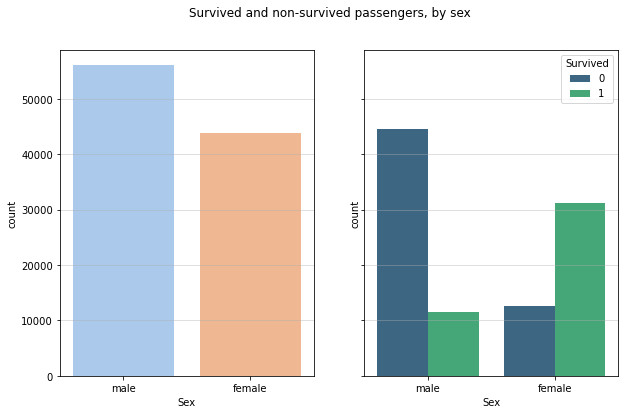

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10,6), sharey=True)
plt.suptitle('Survived and non-survived passengers, by sex', fontsize = 12)
sns.countplot(ax=axes[0], x="Sex", data=data, palette="pastel")
sns.countplot(ax=axes[1], x="Sex", hue='Survived', data=data, palette="viridis")
axes[0].grid(axis = 'y', alpha = 0.5)
axes[1].grid(axis = 'y', alpha = 0.5)

We notice the relationship between the gender and the survival. The number of survived women is greater than the number of survived men, nevertheless the number if male passengers is greater than the number of female passengers.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

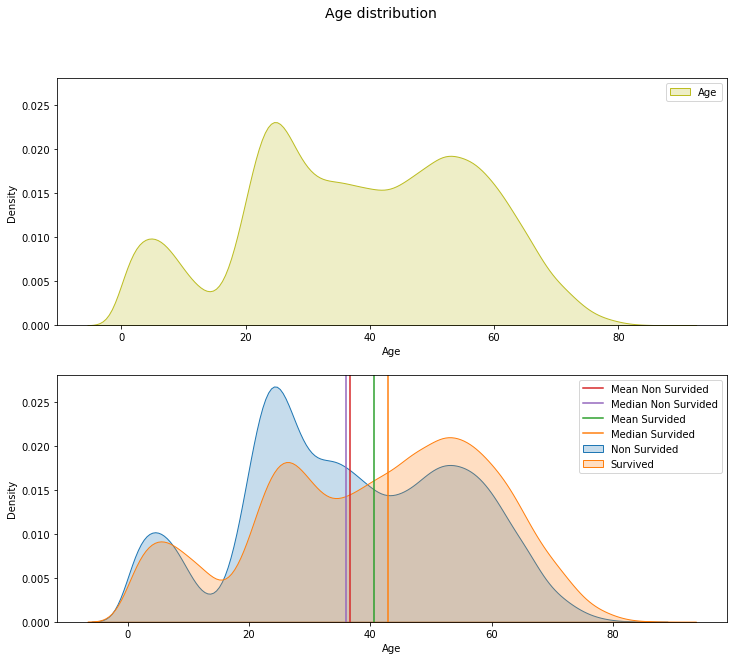

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(12,10), sharey=True)
plt.suptitle("Age distribution", fontsize = 14)
sns.kdeplot(ax=axes[0], x='Age', data=data,  shade=True, color="C8", label='Age')
sns.kdeplot(ax=axes[1], x=data[data['Survived']==0]['Age'],data=data,  shade=True, palette="Winter" ,label='Non Survided')
sns.kdeplot(ax=axes[1], x=data[data['Survived']==1]['Age'],data=data, shade=True, palette="Autumn" ,label='Survived')
plt.axvline(x=data[data['Survived']==0]['Age'].mean(), color = 'C3', label='Mean Non Survided')
plt.axvline(x=data[data['Survived']==0]['Age'].median(), color = 'C4', label='Median Non Survided')
plt.axvline(x=data[data['Survived']==1]['Age'].mean(), color = 'C2', label='Mean Survided')
plt.axvline(x=data[data['Survived']==1]['Age'].median(), color = 'C1', label='Median Survided')
axes[0].legend(['Age'])
axes[1].legend(['Mean Non Survided','Median Non Survided', 'Mean Survided','Median Survided', 'Non Survided','Survived'])
plt.show()

In [35]:
nsv = data[data['Survived']==0]['Age'].describe()
sv = data[data['Survived']==1]['Age'].describe()
age_stat = pd.DataFrame({'Non Survived': nsv, 'Survived': sv}).T
age_stat

,count,mean,std,min,25%,50%,75%,max
Non Survived,55290.0,36.708695,17.809058,0.08,24.0,36.0,52.0,83.0
Survived,41418.0,40.553799,18.742172,0.08,27.0,43.0,55.0,87.0


Most of the passengers were between the ages of 20 and 60, with quite a few children under 10.

The average age of survived passengers is 40.553799.
The median age of survived passengers is 43.
The average age of non-survived passengers is 36.708695.
The median age of non-survived passengers is 36.

Age distributions differ for survived and non-survived passengers. The highest chance of survive is among older passengers and teenagers, the smallest chance of survive is among passengers of 20-40 years. This is probably due to the fact that elderly passengers and children were rescued in priority.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

<AxesSubplot:xlabel='Embarked', ylabel='count'>

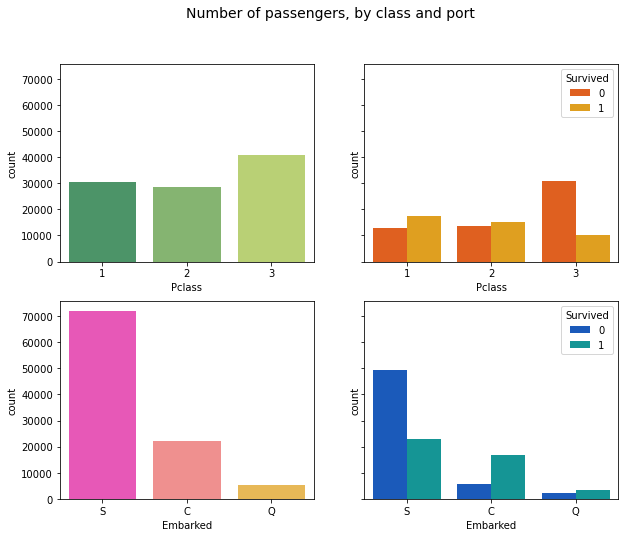

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(10,8), sharey=True)
plt.suptitle('Number of passengers, by class and port', fontsize = 14)
sns.countplot(ax=axes[0,0], x="Pclass", data=data, palette="summer")
sns.countplot(ax=axes[0,1], x="Pclass", hue='Survived', data=data, palette="autumn")
sns.countplot(ax=axes[1,0], x="Embarked", data=data, palette="spring")
sns.countplot(ax=axes[1,1], x="Embarked", hue='Survived', data=data, palette="winter")

The most passeners had third class tickets. In the first class there was the highest probability to survive, in the second class the chance to survive decreased, and the worst probability to survive was in the third (largest) class.

Most of the passengers embarked at the first port. Passengers boarded the ship in the second and third ports were more likely to survive.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [37]:
print('The percentage of missing values for each feature')
(data.isna().sum()*100/data.shape[0]).sort_values(ascending=False)

The percentage of missing values for each feature


Cabin       67.866
Ticket       4.623
Age          3.292
Embarked     0.250
Fare         0.134
Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
SibSp        0.000
Parch        0.000
dtype: float64

There are five features with missing values. The most missing values percentage has feature 'Cabin'.

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

To handle the missing values for modelling we can:

    1. Delete rows or columns with missing values. But in this case we reduse information about our data.
    
    2. Fill the missing values with mean or median value. It works well for data with normal distribution. But it may lead to a bias.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

Let's delete columns 'Name' as useless.

Let's delete columns 'Ticket' and 'Cabin' with missing values.

Let's fill the missing values in 'Age' and 'Fare' with it's medians.

Let's fill the missing values in 'Embarked' with it's mode.

In [38]:
# data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
data = data.drop(columns=['Name', 'Ticket', 'Cabin'])
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Fare'].fillna(data['Fare'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode(dropna=True), inplace=True)

Let's code the features 'Sex' and 'Embarked' to make them numerical.

In [39]:
data = pd.concat((data, pd.get_dummies(data['Sex'])), axis=1)
data = pd.concat((data, pd.get_dummies(data['Embarked'])), axis=1)
data = data.drop(columns=['Sex', 'Embarked'])
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
PassengerId,,,,,,,,,,,
0,1,1,39.00,2,0,27.14,0,1,0,0,1
1,0,3,39.00,0,0,13.35,0,1,0,0,1
2,0,3,0.33,1,2,71.29,0,1,0,0,1
3,0,3,19.00,0,0,13.04,0,1,0,0,1
4,1,3,25.00,0,0,7.76,0,1,0,0,1


In [40]:
feature_cols = ['Pclass','Age','SibSp','Parch','Fare','female','male','C','Q','S']
target = 'Survived'
X = data[feature_cols]
y = data[target]

Let's train the Logistic Regression model.

In [41]:
from sklearn.linear_model import LogisticRegression

results = cross_validate(LogisticRegression(C=10, max_iter=2000), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')

print(f"Logistic Regression train_acc, test_acc = {np.mean(results['train_score']), np.mean(results['test_score'])}")

Logistic Regression train_acc, test_acc = (0.7667475, 0.76671)


Let's train the KNN model.

In [42]:
from sklearn.neighbors import KNeighborsClassifier

results = cross_validate(KNeighborsClassifier(n_neighbors=4), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')

print(f"KNN train_acc, test_acc = {np.mean(results['train_score']), np.mean(results['test_score'])}")

KNN train_acc, test_acc = (0.8116625, 0.71971)


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Let's train the Logistic Regression model with different C.

In [43]:
results = cross_validate(LogisticRegression(C=5, max_iter=2000), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')

print(f"Logistic Regression train_acc, test_acc = {np.mean(results['train_score']), np.mean(results['test_score'])}")

Logistic Regression train_acc, test_acc = (0.7667324999999999, 0.76666)


In [44]:
results = cross_validate(LogisticRegression(C=50, max_iter=2000), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')

print(f"Logistic Regression train_acc, test_acc = {np.mean(results['train_score']), np.mean(results['test_score'])}")

Logistic Regression train_acc, test_acc = (0.76662, 0.7667299999999999)


In [45]:
results = cross_validate(LogisticRegression(C=100, max_iter=2000), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')

print(f"Logistic Regression train_acc, test_acc = {np.mean(results['train_score']), np.mean(results['test_score'])}")

Logistic Regression train_acc, test_acc = (0.7666799999999999, 0.76684)


In [46]:
results = cross_validate(LogisticRegression(C=500, max_iter=2000), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')

print(f"Logistic Regression train_acc, test_acc = {np.mean(results['train_score']), np.mean(results['test_score'])}")

Logistic Regression train_acc, test_acc = (0.7666875, 0.7666700000000001)


We can see that for big values of C (C=500 in our example) the model overfits the data.
Let's set optimal C=100.

Let's train the KNN model with different k.

In [47]:
results = cross_validate(KNeighborsClassifier(n_neighbors=3), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')

print(f"KNN train_acc, test_acc = {np.mean(results['train_score']), np.mean(results['test_score'])}")

KNN train_acc, test_acc = (0.8414949999999999, 0.71957)


In [48]:
results = cross_validate(KNeighborsClassifier(n_neighbors=5), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')

print(f"KNN train_acc, test_acc = {np.mean(results['train_score']), np.mean(results['test_score'])}")

KNN train_acc, test_acc = (0.810195, 0.7332599999999999)


We can see that under fitting KNN model the accuracy on the test set is worse than under fitting Logistic Regression.

Let's load the test set and make the predictions using the model LogisticRegression(C=100, max_iter=2000).

In [49]:
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

data_test = data_test.drop(columns=['Name', 'Ticket', 'Cabin'])
data_test['Age'].fillna(data_test['Age'].median(), inplace=True)
data_test['Fare'].fillna(data_test['Fare'].median(), inplace=True)
data_test['Embarked'].fillna(data_test['Embarked'].mode(dropna=True), inplace=True)
data_test = pd.concat((data_test, pd.get_dummies(data_test['Sex'])), axis=1)
data_test = pd.concat((data_test, pd.get_dummies(data_test['Embarked'])), axis=1)
data_test = data_test.drop(columns=['Sex', 'Embarked'])
data_test.head()

X_test = data_test[['Pclass','Age','SibSp','Parch','Fare','female','male','C','Q','S']]

logreg = (LogisticRegression(C=100, max_iter=2000))
logreg.fit(X,y)
data_test['Survived'] = logreg.predict(X_test)
data_test = data_test.drop(columns=feature_cols)
data_test.to_csv('./titanic.csv')
data_test.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,0


After submitting my model's predictions to kaggle I receive Score: 0.76555 (Anna Zaretskaya).

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.